In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
DATA_SOURCE = "BMW Car Data Analysis — Kaggle Dataset"

# Try to import xgboost; if unavailable, the code will skip XGB model but still run others.
try:
  from xgboost import XGBRegressor
  XGB_AVAILABLE = True
except Exception:
  XGB_AVAILABLE = False

In [ ]:
# For saving model
import joblib

In [ ]:
# 2. Helper functions

def rmse(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_regression(y_true, y_pred):
  return {
    'MAE': mean_absolute_error(y_true, y_pred),
    'RMSE': rmse(y_true, y_pred),
    'R2': r2_score(y_true, y_pred)
  }

def plot_pred_vs_true(y_true, y_pred, title=None):
    plt.figure(figsize=(7,7))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    maxv = max(max(y_true), max(y_pred))
    minv = min(min(y_true), min(y_pred))
    plt.plot([minv, maxv], [minv, maxv], '--')
    plt.xlabel('True Price')
    plt.ylabel('Predicted Price')
    if title:
      plt.title(title)
    plt.grid(True)
    plt.show()

In [ ]:
def calculate_vif(df_num):
    """Calculate VIF for numeric dataframe df_num (no constant added). Returns DataFrame."""
    X = df_num.copy()
    # Add constant term for VIF? variance_inflation_factor doesn't require intercept column
    vif_data = []
    for i in range(X.shape[1]):
        vif = variance_inflation_factor(X.values, i)
        vif_data.append({'feature': X.columns[i], 'VIF': vif})
    return pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

Data source (placeholder): BMW Car Data Analysis — Kaggle Dataset
No local file found. Please upload your dataset CSV (e.g. bmw.csv).


Saving archive.zip to archive (6).zip

========== DATASET SAMPLE (first 20 rows) ==========
        model  year  price transmission  mileage fuelType  tax    mpg  \
0    5 Series  2014  11200    Automatic    67068   Diesel  125   57.6   
1    6 Series  2018  27000    Automatic    14827   Petrol  145   42.8   
2    5 Series  2016  16000    Automatic    62794   Diesel  160   51.4   
3    1 Series  2017  12750    Automatic    26676   Diesel  145   72.4   
4    7 Series  2014  14500    Automatic    39554   Diesel  160   50.4   
5    5 Series  2016  14900    Automatic    35309   Diesel  125   60.1   
6    5 Series  2017  16000    Automatic    38538   Diesel  125   60.1   
7    2 Series  2018  16250       Manual    10401   Petrol  145   52.3   
8    4 Series  2017  14250       Manual    42668   Diesel   30   62.8   
9    5 Series  2016  14250    Automatic    36099   Diesel   20   68.9   
10         X3  2017  15500       Manual    74907   Diesel  145   52.3   
11   1 Series  2017  11800      

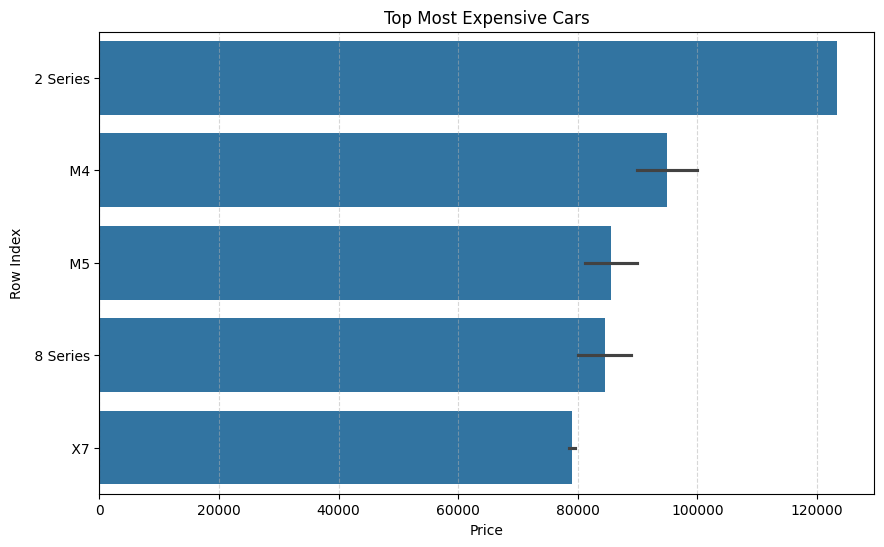


Top 10 most expensive cars:


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
3638,2 Series,2015,123456,Semi-Auto,33419,Diesel,20,68.9,2.0
5362,M4,2016,99950,Automatic,771,Petrol,300,33.2,3.0
2909,M4,2017,89990,Semi-Auto,1336,Petrol,145,33.2,3.0
4776,M5,2019,89900,Semi-Auto,2269,Petrol,145,24.1,4.4
1813,8 Series,2019,88980,Semi-Auto,88,Petrol,145,24.4,4.4
721,8 Series,2019,84898,Semi-Auto,3185,Petrol,145,24.4,4.4
5877,M5,2019,81140,Semi-Auto,551,Petrol,145,24.1,4.4
6115,8 Series,2020,79991,Semi-Auto,151,Diesel,145,26.7,3.0
7024,X7,2020,79566,Semi-Auto,1000,Petrol,145,24.8,3.0
2602,X7,2020,78490,Semi-Auto,4919,Diesel,145,31.4,3.0


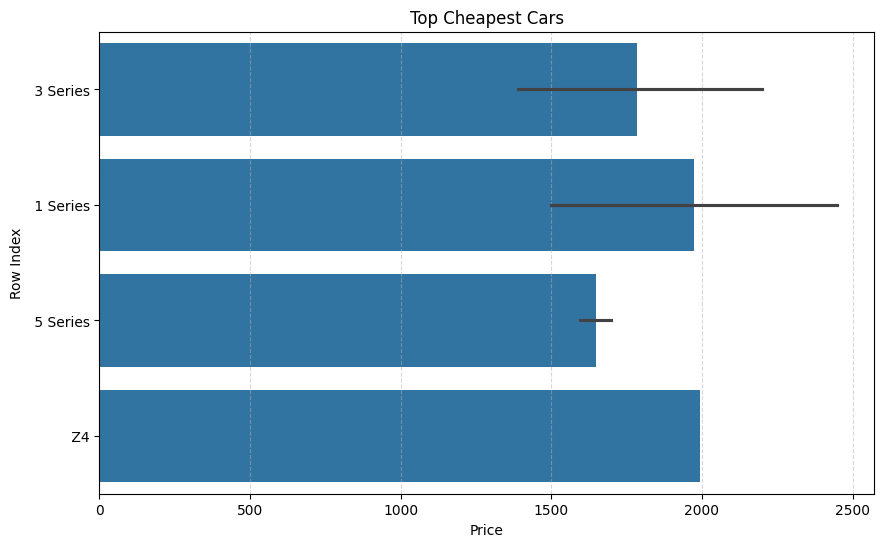


Top 10 cheapest cars:


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
9744,3 Series,1999,1200,Automatic,82000,Petrol,245,31.0,2.8
9696,3 Series,2004,1445,Manual,162000,Diesel,205,49.6,2.0
9554,1 Series,2007,1500,Manual,167000,Diesel,125,57.6,2.0
10006,3 Series,2000,1550,Automatic,93000,Petrol,270,29.7,2.5
7284,5 Series,2002,1595,Automatic,115000,Petrol,325,28.5,2.2
9406,5 Series,2000,1699,Manual,99209,Petrol,265,29.4,2.0
9963,Z4,2004,1995,Manual,114000,Petrol,325,32.1,2.2
10009,3 Series,2002,2350,Manual,99000,Petrol,325,30.1,2.2
9220,3 Series,2007,2375,Manual,94000,Petrol,240,38.7,2.0
9918,1 Series,2010,2450,Manual,117454,Diesel,30,62.8,2.0


In [ ]:
# 3. Data loading
# Option A: If running interactively in Colab, allow upload

print("Data source (placeholder):", DATA_SOURCE)

try:
    # Try to read common filenames if present in environment
    if os.path.exists('bmw.csv'):
        df = pd.read_csv('bmw.csv')
    elif os.path.exists('BMW.csv'):
        df = pd.read_csv('BMW.csv')
    else:
      # Fallback: prompt user to upload (works in Colab)
      from google.colab import files # type: ignore
      print('No local file found. Please upload your dataset CSV (e.g. bmw.csv).')
      uploaded = files.upload()
      # take the first file
      first_file = list(uploaded.keys())[0]
      df = pd.read_csv(first_file)
except Exception as e:
    raise RuntimeError("Failed to load dataset. If in non-Colab environment, place bmw.csv next to this notebook or modify path.") from e

# === SHOW DATASET SAMPLE (NEW BLOCK) ===

print("\n========== DATASET SAMPLE (first 20 rows) ==========")
print(df.head(20))       # Если обычная консоль
print('\nData loaded — shape:', df.shape)
print('Columns:', df.columns.tolist())

# === TOP 10 MOST EXPENSIVE CARS ===

top10_expensive = df.nlargest(10, target_col)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top10_expensive,
    x=target_col,
    y=top10_expensive.model,
)
plt.title("Top Most Expensive Cars")
plt.xlabel("Price")
plt.ylabel("Row Index")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

print("\nTop 10 most expensive cars:")
display(top10_expensive)

# === TOP 10 CHEAPEST CARS ===

top10_cheapest = df.nsmallest(10, target_col)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top10_cheapest,
    x=target_col,
    y=top10_cheapest.model,
)
plt.title("Top Cheapest Cars")
plt.xlabel("Price")
plt.ylabel("Row Index")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

print("\nTop 10 cheapest cars:")
display(top10_cheapest)


In [ ]:
# 4. Quick EDA
df.head()

print('\nData info:')
df.info()

print('\nBasic description (numerical):')
df.describe().T

# Identify target and candidate features
# Common column names in car datasets: 'price', 'Year', 'Mileage', 'Engine', 'Transmission', 'FuelType', 'Tax', 'MPG', 'EngineSize'
# User: if your dataset uses other names, adapt the variable 'target_col' and feature selection below.

# Try common target column names
possible_targets = ['price', 'Price', 'listing_price', 'SalePrice']
target_col = None
for t in possible_targets:
    if t in df.columns:
        target_col = t
        break

if target_col is None:
    raise ValueError("Couldn't find target column automatically. Rename your price column to 'price' or set target_col manually.")

print('\nTarget column detected as:', target_col)


Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   tax           10781 non-null  int64  
 7   mpg           10781 non-null  float64
 8   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB

Basic description (numerical):

Target column detected as: price


In [ ]:
# Basic missing values overview
miss = df.isnull().sum().sort_values(ascending=False)
miss = miss[miss>0]
print('\nColumns with missing values:\n', miss)


Columns with missing values:
 Series([], dtype: int64)


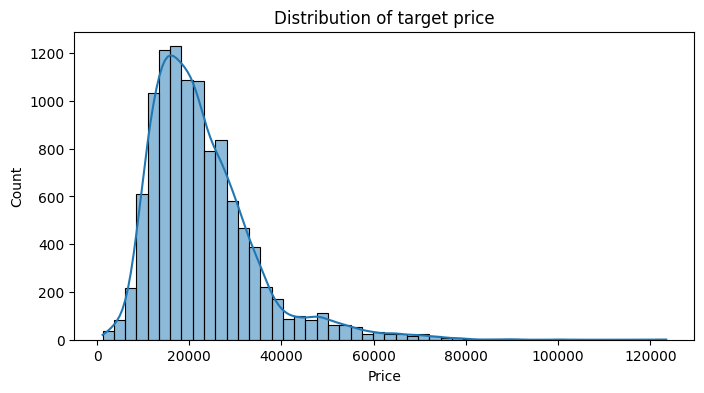

In [ ]:
# Quick visualization: distribution of price
plt.figure(figsize=(8,4))
sns.histplot(df[target_col].dropna(), bins=50, kde=True)
plt.title('Distribution of target price')
plt.xlabel('Price')
plt.show()

In [ ]:
# 5. Preprocessing decisions
# Split numerical vs categorical columns heuristically
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

In [ ]:
# Remove target from num_cols if present
if target_col in num_cols:
    num_cols.remove(target_col)

print('\nNumerical columns (detected):', num_cols)
print('Categorical columns (detected):', cat_cols)

for c in ['Year', 'year', 'yr']:
    if c in df.columns and not np.issubdtype(df[c].dtype, np.number):
      df[c] = pd.to_numeric(df[c], errors='coerce')
      if c not in num_cols:
          num_cols.append(c)
          if c in cat_cols: cat_cols.remove(c)


Numerical columns (detected): ['year', 'mileage', 'tax', 'mpg', 'engineSize']
Categorical columns (detected): ['model', 'transmission', 'fuelType']


In [ ]:
# Feature engineering: example - extract age of car from Year if present
CURRENT_YEAR = pd.Timestamp.now().year
if 'Year' in df.columns or 'year' in df.columns:
    year_col = 'Year' if 'Year' in df.columns else 'year'
    df['car_age'] = CURRENT_YEAR - df[year_col]
    num_cols.append('car_age')
    print('\nAdded feature car_age based on', year_col)


Added feature car_age based on year


In [ ]:
# Handle mileage column name variations
for m in ['Mileage','mileage','miles']:
    if m in df.columns and m not in num_cols:
        try:
            df[m] = pd.to_numeric(df[m].astype(str).str.replace(',',''), errors='coerce')
            num_cols.append(m)
            if m in cat_cols: cat_cols.remove(m)
        except Exception:
            pass

In [ ]:
# Keep a reduced set of features: choose top candidates
# We'll keep numeric features and a limited set of categorical features (like Transmission, FuelType, Model)
candidate_cat = []
for c in ['Transmission','transmission','FuelType','fuelType','Model','model','Brand','brand']:
    if c in df.columns and c not in candidate_cat:
        candidate_cat.append(c)

print('\nCandidate categorical features to keep if present:', candidate_cat)


Candidate categorical features to keep if present: ['transmission', 'fuelType', 'model']


In [ ]:
# Subset columns to those available
features = []
for c in num_cols:
    features.append(c)
for c in candidate_cat:
    if c in df.columns:
        features.append(c)

In [ ]:
# Ensure features are unique and exist
features = [f for f in list(dict.fromkeys(features)) if f in df.columns]
print('\nFeatures that will be used (automatic selection):', features)


Features that will be used (automatic selection): ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'car_age', 'transmission', 'fuelType', 'model']


In [ ]:
# 6. Build preprocessing pipeline
numeric_features = [c for c in features if c in df.select_dtypes(include=[np.number]).columns]
categorical_features = [c for c in features if c not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [ ]:
# 7. Prepare data (drop rows with missing target)
df = df.dropna(subset=[target_col])
X = df[features].copy()
y = df[target_col].astype(float)


# Quick train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print('\nTrain shape:', X_train.shape, 'Test shape:', X_test.shape)


# %%
# 8. Multicollinearity check (VIF) on numeric features after simple imputation
# We'll impute numeric columns with median for VIF calculation
X_num = X_train[numeric_features].copy()
X_num = X_num.fillna(X_num.median())


if X_num.shape[1] > 0:
    vif_df = calculate_vif(X_num)
    print('\nVIF (numeric features):')
    print(vif_df)
else:
    print('\nNo numeric features for VIF calculation.')


Train shape: (8624, 9) Test shape: (2157, 9)

VIF (numeric features):
      feature        VIF
0        year  46.416567
5     car_age  31.854015
1     mileage   2.708972
2         tax   1.368584
4  engineSize   1.338637
3         mpg   1.264125


In [ ]:
# 9. Models to train: LinearRegression, RandomForestRegressor, XGBRegressor (if available)

# Model pipelines
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))])
if XGB_AVAILABLE:
    xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', XGBRegressor(random_state=42, n_jobs=1))])

In [ ]:
# 10. Fit models (use default hyperparams; optionally grid search later)
print('\nTraining Linear Regression...')
lr_pipeline.fit(X_train, y_train)
print('Done.')

print('\nTraining Random Forest...')
rf_pipeline.fit(X_train, y_train)
print('Done.')

if XGB_AVAILABLE:
    print('\nTraining XGBoost...')
    xgb_pipeline.fit(X_train, y_train)
    print('Done.')
else:
    print('\nXGBoost not available in this environment. To enable, pip install xgboost and restart runtime.')


Training Linear Regression...
Done.

Training Random Forest...
Done.

Training XGBoost...
Done.



LinearRegression metrics:
 {'MAE': 2821.980376044215, 'RMSE': np.float64(4257.787842417903), 'R2': 0.8598093284080306}


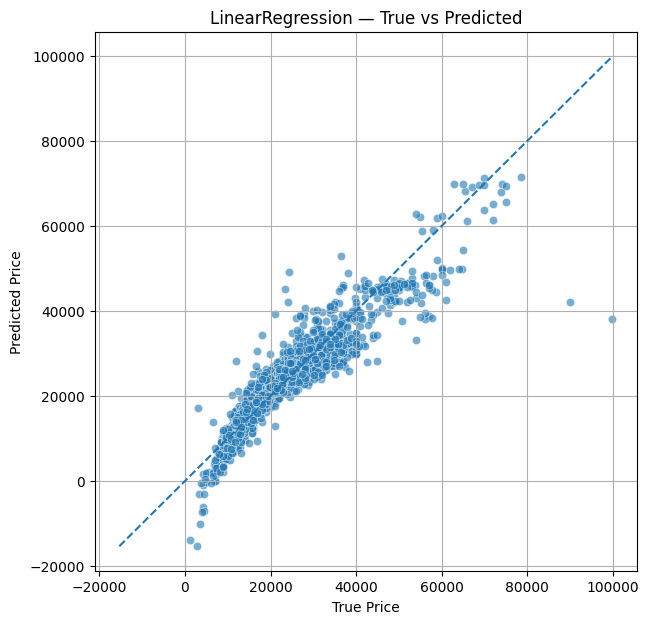


RandomForest metrics:
 {'MAE': 1607.9547196697547, 'RMSE': np.float64(2738.913417559772), 'R2': 0.9419893557996779}


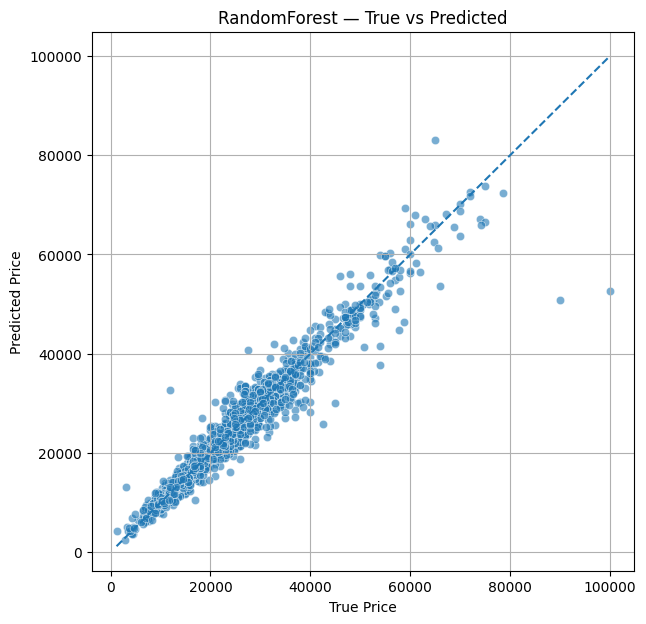


XGBoost metrics:
 {'MAE': 1571.0423867513473, 'RMSE': np.float64(2597.798825489239), 'R2': 0.9478130262606779}


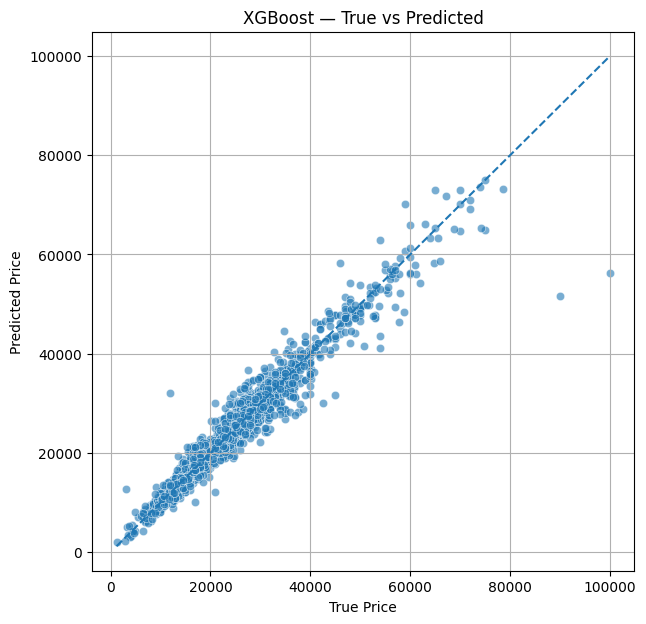

In [ ]:
# 11. Predictions and evaluation
models = {'LinearRegression': lr_pipeline, 'RandomForest': rf_pipeline}
if XGB_AVAILABLE:
    models['XGBoost'] = xgb_pipeline

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    metrics = evaluate_regression(y_test, y_pred)
    results[name] = metrics
    print(f"\n{name} metrics:\n", metrics)
    plot_pred_vs_true(y_test, y_pred, title=f'{name} — True vs Predicted')

In [ ]:
# 12. Compare results in a table
res_df = pd.DataFrame(results).T
res_df = res_df[['MAE','RMSE','R2']]
print('\nComparison of models:')
res_df


Comparison of models:


,MAE,RMSE,R2
LinearRegression,2821.980376,4257.787842,0.859809
RandomForest,1607.954720,2738.913418,0.941989
XGBoost,1571.042387,2597.798825,0.947813


In [ ]:
# 13. Feature importance analysis
# For linear regression: coefficients (after preprocessing we need to map back to original features)
# We'll get feature names from preprocessor

def get_feature_names_from_preprocessor(preprocessor):
    # numeric names
    num_feats = numeric_features
    # categorical names from encoder
    cat_names = []
    if len(categorical_features) > 0:
        cat_transformer = preprocessor.named_transformers_['cat']
        # OneHotEncoder is last step
        ohe = cat_transformer.named_steps['onehot']
        cat_names = list(ohe.get_feature_names_out(categorical_features))
    return num_feats + cat_names


feature_names = get_feature_names_from_preprocessor(preprocessor)


# Linear coefficients
lr_coef = None
try:
    lr_reg = lr_pipeline.named_steps['regressor']
    if hasattr(lr_reg, 'coef_'):
        coef = lr_reg.coef_
        lr_coef = pd.Series(coef, index=feature_names).sort_values(key=abs, ascending=False)
        print('\nTop Linear Regression coefficients:')
        print(lr_coef.head(15))
except Exception as e:
    print('Could not extract linear coefficients:', e)


Top Linear Regression coefficients:
model_ i3          32942.867691
model_ i8          24921.896154
model_ X7          24266.962870
model_ 8 Series    17788.447433
model_ 2 Series   -15122.165789
model_ 1 Series   -15011.709163
model_ M5          13995.942361
model_ X1         -12623.959337
model_ 3 Series   -12354.994788
model_ 4 Series   -12320.589582
model_ X2         -11216.826400
model_ 5 Series   -10380.764914
model_ 6 Series    -9865.757491
model_ Z4          -9393.316500
model_ Z3           7502.117394
dtype: float64


In [ ]:
# Random Forest feature importances
rf_reg = rf_pipeline.named_steps['regressor']
try:
    rf_imp = pd.Series(rf_reg.feature_importances_, index=feature_names).sort_values(ascending=False)
    print('\nTop Random Forest feature importances:')
    print(rf_imp.head(15))
except Exception as e:
    print('Could not extract RF importances:', e)


Top Random Forest feature importances:
engineSize             0.265332
car_age                0.246591
year                   0.206519
mpg                    0.083233
mileage                0.062392
model_ i8              0.017320
transmission_Manual    0.015458
model_ X5              0.014998
model_ X7              0.012224
tax                    0.008964
model_ 8 Series        0.008439
model_ X3              0.007586
model_ 7 Series        0.007539
model_ 2 Series        0.007515
model_ 1 Series        0.007071
dtype: float64


In [ ]:
# XGBoost feature importances
if XGB_AVAILABLE:
    xgb_reg = xgb_pipeline.named_steps['regressor']
    try:
        xgb_imp = pd.Series(xgb_reg.feature_importances_, index=feature_names).sort_values(ascending=False)
        print('\nTop XGBoost feature importances:')
        print(xgb_imp.head(15))
    except Exception as e:
        print('Could not extract XGB importances:', e)


Top XGBoost feature importances:
engineSize             0.250230
year                   0.111167
model_ X7              0.102414
model_ i8              0.095175
model_ 8 Series        0.062476
model_ X5              0.053114
transmission_Manual    0.035634
model_ 7 Series        0.030962
model_ 1 Series        0.027292
model_ X6              0.025090
model_ X3              0.022303
fuelType_Petrol        0.021644
model_ 2 Series        0.020955
model_ M5              0.019165
fuelType_Hybrid        0.015062
dtype: float32


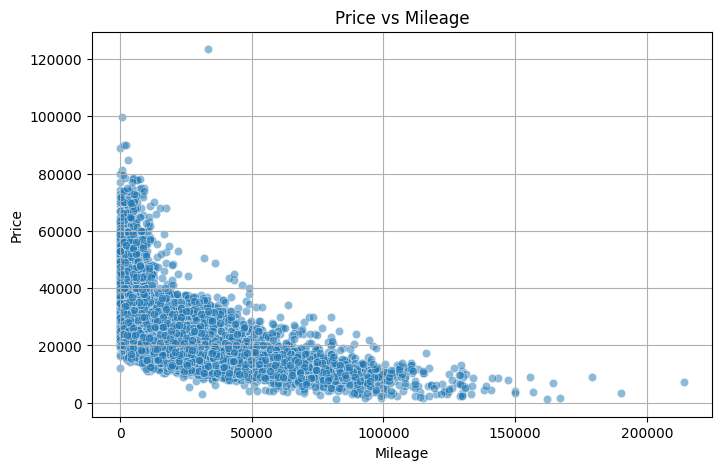

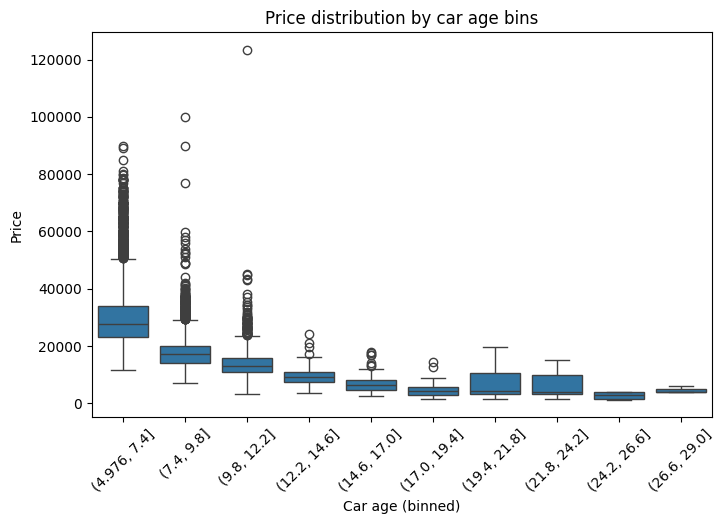

In [ ]:
# 14. Visualizations requested: price vs mileage, price vs year (or car_age)
plt.figure(figsize=(8,5))
if any(m in df.columns for m in ['Mileage','mileage','miles']):
    # choose actual mileage column name
    mileage_col = next((m for m in ['Mileage','mileage','miles'] if m in df.columns), None)
    sns.scatterplot(x=df[mileage_col], y=df[target_col], alpha=0.5)
    plt.xlabel('Mileage')
    plt.ylabel('Price')
    plt.title('Price vs Mileage')
    plt.grid(True)
    plt.show()
else:
    print('No mileage-like column found for Price vs Mileage plot.')


plt.figure(figsize=(8,5))
if 'car_age' in df.columns:
    sns.boxplot(x=pd.cut(df['car_age'], bins=10), y=df[target_col])
    plt.xlabel('Car age (binned)')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.title('Price distribution by car age bins')
    plt.show()
elif any(c in df.columns for c in ['Year','year']):
    year_col = 'Year' if 'Year' in df.columns else 'year'
    sns.scatterplot(x=df[year_col], y=df[target_col], alpha=0.6)
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.title('Price vs Year')
    plt.grid(True)
    plt.show()
else:
    print('No year/car_age column found for Price vs Year plot.')

In [ ]:
# 15. Save models and results
os.makedirs('models', exist_ok=True)
for name, model in models.items():
    fname = f'models/{name}.joblib'
    joblib.dump(model, fname)
    print(f'Saved {name} to {fname}')

# Save results table
res_df.to_csv('models/model_comparison_metrics.csv')
print('Saved model comparison metrics to models/model_comparison_metrics.csv')

Saved LinearRegression to models/LinearRegression.joblib
Saved RandomForest to models/RandomForest.joblib
Saved XGBoost to models/XGBoost.joblib
Saved model comparison metrics to models/model_comparison_metrics.csv


In [ ]:
# 16. Short report / interpretation (print to output)
print('\n--- ANALYTICAL SUMMARY (automatically generated) ---')
print(f"Dataset source (placeholder): {DATA_SOURCE}")
print('Used features:', features)
print('\nModel comparison:')
print(res_df)


# Interpret top factors from Random Forest as main drivers of price
if 'rf_imp' in locals():
    top_rf = rf_imp.head(8)
    print('\nTop factors influencing price (Random Forest importance):')
    for feat, val in top_rf.items():
        print(f' - {feat}: importance {val:.4f}')


print('\nNotes and recommendations:')
print(' - If VIF shows multicollinearity (VIF > 5-10), consider dropping or combining correlated features.')
print(' - Consider hyperparameter tuning (GridSearchCV) for RandomForest/XGBoost to improve performance.')
print(' - Consider more advanced feature engineering: interaction terms, polynomial features for mileage/age, text parsing of model names.')


--- ANALYTICAL SUMMARY (automatically generated) ---
Dataset source (placeholder): BMW Car Data Analysis — Kaggle Dataset
Used features: ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'car_age', 'transmission', 'fuelType', 'model']

Model comparison:
                          MAE         RMSE        R2
LinearRegression  2821.980376  4257.787842  0.859809
RandomForest      1607.954720  2738.913418  0.941989
XGBoost           1571.042387  2597.798825  0.947813

Top factors influencing price (Random Forest importance):
 - engineSize: importance 0.2653
 - car_age: importance 0.2466
 - year: importance 0.2065
 - mpg: importance 0.0832
 - mileage: importance 0.0624
 - model_ i8: importance 0.0173
 - transmission_Manual: importance 0.0155
 - model_ X5: importance 0.0150

Notes and recommendations:
 - If VIF shows multicollinearity (VIF > 5-10), consider dropping or combining correlated features.
 - Consider hyperparameter tuning (GridSearchCV) for RandomForest/XGBoost to improve performance